Este projeto tem por objetivo realizar o reconhecimento facial de duas pessoas.

No caso, estou utilizando como base de dados as fotos de dois presidentes americanos (Barack Obama e Joe Bide).

É bem verdade que podemos inserir outros presidentes porém quanto mais classes inserimos mais poder de processamento computacional necessitamos.

Como o objetivo do desafio é mostrar como funciona a técnica do aprendizado de máquina do início ao fim para o reconhecimento facial, trouxe apenas esses exemplares.



(English Translate)



"The objective of this project is to recognize two faces.

I've built the dataset using photos of Barack Obama and Joe Biden.

Although we can add more classes, it's important to note that more labels demand more processing computational power.

To show how the entire facial recognition pipeline works from start to finish, I focused on these two examples."

O primeiro passo é importar as bibliotecas que serão utilizadas ao longo do código

(English Translate)

The first step is to import the libraries that will be used throughout the code.

In [ ]:
# Importando as bibliotecas

!pip -q install -U mtcnn

import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from mtcnn import MTCNN



Precisamos que ter acesso ao drive, já que estamos usano o Google Colab

(English Translate)

We need to access the drive, since we are using Google Colab.

In [ ]:
# Acesso ao Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definindo o parâmetro para as imagens do treinamento, ou seja:

IMG_SIZE = Tamanho de cada imagem do dataset.

BATCH_SIZE = Quantidade de imagens processadas de uma vez durante o treino

(English Translate)

Defining the parameters for the training images, namely:

IMG_SIZE = the size of each image in the dataset.

BATCH_SIZE = the number of images processed at once during training.

In [ ]:
# Configurações básicas
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# (opcional) pasta local no Colab — não é onde vamos salvar o modelo
os.makedirs('models', exist_ok=True)


Gerando os dados com a função Data Augmentation onde o objetivo é rotacionar, aumentar ou diminuir o tamanho da foto para que tenhamos mais possibilidade de imagens.

(English Translate)

Generating data using the Data Augmentation function, aiming to rotate, zoom, or scale images to increase the variety of the dataset

In [ ]:
# 1. Geradores de Dados com Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/RECONHECIMENTO_FACIAL/USA/Presidentes/train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/RECONHECIMENTO_FACIAL/USA/Presidentes/validation/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)



Found 46 images belonging to 2 classes.
Found 19 images belonging to 2 classes.



Faz a chamada da rede ResNet50 e seus devidos parâmetros


(English Translate)

Call the ResNet50 network with its corresponding parameters


In [ ]:
# 2. Construção do Modelo (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Treina apenas o modelo

(English Translate)

Executes training for the model only

In [ ]:
# Treinamento do modelo
print("\nIniciando primeira fase de treino (camadas superiores)...")
history1 = model.fit(train_gen, validation_data=val_gen, epochs=10)




Iniciando primeira fase de treino (camadas superiores)...
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 13s/step - accuracy: 0.4814 - loss: 1.1419 - val_accuracy: 0.4737 - val_loss: 0.8018
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.5747 - loss: 0.9957 - val_accuracy: 0.6842 - val_loss: 0.7302
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 10s/step - accuracy: 0.6304 - loss: 0.6833 - val_accuracy: 0.6316 - val_loss: 0.9704
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.7468 - loss: 0.5991 - val_accuracy: 0.5789 - val_loss: 0.7066
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - accuracy: 0.7636 - loss: 0.4643 - val_accuracy: 0.5263 - val_loss: 0.6310
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 8s/step - accuracy: 0.8892 - loss: 0.2334 - val_accuracy: 0.7368 - val_loss: 0.6123
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.8714 - loss: 0.2246 - val_accuracy: 0.7368 - val_loss: 0.5735
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 10s/step - accuracy: 0.8561 - l

A função congela todas as camasdas exceto as 2 últimas

(English Translate)


The function freezes all layers except for the last two

In [ ]:
# --- SEGUNDA FASE: FINE-TUNING (DESCONGELAR CAMADAS DA BASE) ---
print("\nIniciando Fine-Tuning: descongelando últimas camadas da ResNet50...")

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nIniciando segunda fase de treino (Fine-Tuning nas últimas 30 camadas)...")
history2 = model.fit(train_gen, validation_data=val_gen, epochs=20)

# Combina os históricos para um gráfico contínuo
history_combined = {}
for key in history1.history.keys():
    history_combined[key] = history1.history[key] + history2.history[key]




Iniciando Fine-Tuning: descongelando últimas camadas da ResNet50...

Iniciando segunda fase de treino (Fine-Tuning nas últimas 30 camadas)...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 12s/step - accuracy: 0.8320 - loss: 0.3569 - val_accuracy: 0.8421 - val_loss: 0.3110
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.8219 - loss: 0.4317 - val_accuracy: 0.8421 - val_loss: 0.3076
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.9182 - loss: 0.2430 - val_accuracy: 0.8421 - val_loss: 0.3073
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.8175 - loss: 0.4820 - val_accuracy: 0.8421 - val_loss: 0.3114
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.8714 - loss: 0.2386 - val_accuracy: 0.8421 - val_loss: 0.3173
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.8714 - loss: 0.2771 - val_accuracy: 0.8421 - val_loss: 0.3248
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.8361 - loss: 0.2715 - val_accuracy: 0.8421 - val

Mostra a Acurácia antes e depois do treinamento

Mostra a Perda antes e depois do treinamento

(English Translate)

Shows Accuracy before and after training.

Shows Loss before and after training.

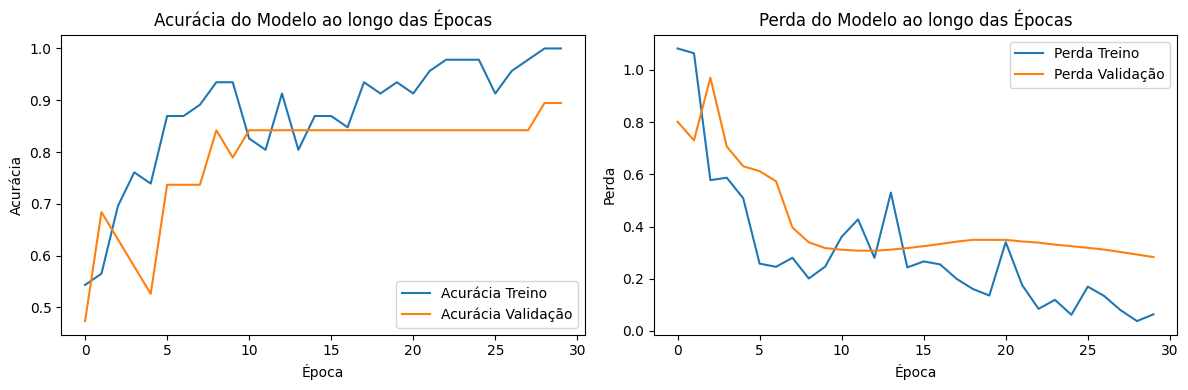

In [ ]:
# --- FUNÇÃO PARA PLOTAR GRÁFICOS ---
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Acurácia Treino')
    plt.plot(history['val_accuracy'], label='Acurácia Validação')
    plt.title('Acurácia do Modelo ao longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Perda Treino')
    plt.plot(history['val_loss'], label='Perda Validação')
    plt.title('Perda do Modelo ao longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_combined)



Salva no drive modelo treinado (arquitetura da rede, pesos treinados, função de ativação etc).

É nesse momento que garantimos que o nomen do Presidente seja correto, não exista confusão de lables e o bounding box apareça


(English Translate)


Saves the trained model to Drive (including network architecture, weights, activation functions, etc.).

This step ensures the President's name is accurate, labels are consistent, and bounding boxes are correctly rendered

In [ ]:

# ✅ Caminho no drive
MODEL_PATH = '/content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/RECONHECIMENTO_FACIAL/USA/Presidentes/models/face_classifier.h5'
MODEL_CLASS = '/content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/RECONHECIMENTO_FACIAL/USA/Presidentes/models/classes.txt'

# garante a pasta models no Drive
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

# salva modelo
model.save(MODEL_PATH)

# ✅ Salva classes.txt exatamente no mesmo caminho que será lido depois
labels = sorted(train_gen.class_indices.keys())
with open(MODEL_CLASS, 'w', encoding='utf-8') as f:
    for label in labels:
        f.write(f"{label}\n")

print("Treinamento concluído e modelo salvo com sucesso!")
print("Modelo:", MODEL_PATH)
print("Classes:", MODEL_CLASS)



Treinamento concluído e modelo salvo com sucesso!
Modelo: /content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/RECONHECIMENTO_FACIAL/USA/Presidentes/models/face_classifier.h5
Classes: /content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/RECONHECIMENTO_FACIAL/USA/Presidentes/models/classes.txt


Fução criada para inserir uma imagem externa

(English Translate)


Function created to insert an external image

In [ ]:
# Criação da função

def validar_multiplos_presidentes(caminho_foto):
    # Carrega modelo e labels
    modelo = load_model(MODEL_PATH)
    with open(MODEL_CLASS, 'r', encoding='utf-8') as f:
        labels = [line.strip() for line in f.readlines()]

    print(f"Rótulos lidos do classes.txt: {labels}")

    img_bgr = cv2.imread(caminho_foto)
    if img_bgr is None:
        raise ValueError(f"Não consegui ler a imagem: {caminho_foto}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    detector = MTCNN()
    faces_detected_mtcnn = detector.detect_faces(img_rgb)

    print(f"Rostos detectados pelo MTCNN: {len(faces_detected_mtcnn)}")

    for face_info in faces_detected_mtcnn:
        x, y, w, h = face_info['box']
        x, y = max(0, x), max(0, y)

        rosto = img_rgb[y:y+h, x:x+w]
        if rosto.size == 0:
            continue

        rosto_input = cv2.resize(rosto, (224, 224))
        img_array = np.expand_dims(rosto_input, axis=0).astype(np.float32)
        img_preprocessed = preprocess_input(img_array)

        preds = modelo.predict(img_preprocessed, verbose=0)
        classe_id = int(np.argmax(preds))
        confianca = float(np.max(preds))
        nome = labels[classe_id] if classe_id < len(labels) else f"classe_{classe_id}"

        print(f"Rosto detectado (ID: {classe_id}) - Nome previsto: {nome}, Confiança: {confianca*100:.1f}%")

        cor = (0, 255, 0)
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), cor, 2)

        # ✅ Se você NÃO quiser o número "1.00", use só `nome`
        texto = nome  # <- só nome
        # Se quiser com %: texto = f"{nome} ({confianca*100:.1f}%)"

        font_scale = max(0.45, w / 300)
        thickness = 1

        cv2.putText(
            img_rgb,
            texto,
            (x, max(15, y - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            cor,
            thickness,
            cv2.LINE_AA
        )

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()



Chamada da função com o caminho de uma imagem externa

(English Translate)


Function call with the external image path

Rótulos lidos do classes.txt: ['Barack_Obama', 'Joe_Biden']
Rostos detectados pelo MTCNN: 2
Rosto detectado (ID: 1) - Nome previsto: Joe_Biden, Confiança: 64.8%
Rosto detectado (ID: 0) - Nome previsto: Barack_Obama, Confiança: 99.3%


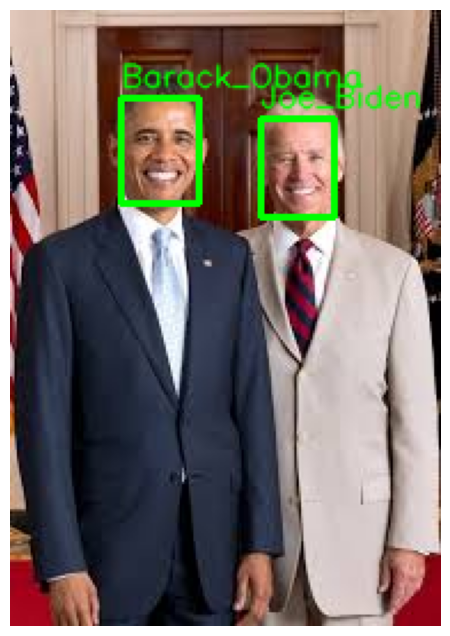

In [ ]:
# CHAMADA DA FUNÇÃO DE TESTE
validar_multiplos_presidentes(
    '/content/drive/MyDrive/Datasets/DESAFIOS_CODIGOS/RECONHECIMENTO_FACIAL/OBAMA_BIDDEN_testando.jpg'
)